### Configuration: number of files and ServiceX usage

In [1]:
# GLOBAL CONFIGURATION
N_FILES_MAX_PER_SAMPLE = 10  # input files per process, set to -1 for no limit / 1 or 10 for quick debugging  
USE_SERVICEX = True
USE_DASK = False
SERVICEX_IGNORE_CACHE = True  # set to True to force re-running of transforms
# 500 files
# -> 20 min with ServiceX on coffea-casa
# -> ~ 5 min with pure coffea

### Processor

In [2]:
import time
import asyncio

import awkward as ak
from coffea import processor
from coffea.processor import servicex
import hist
import json
import numpy as np
import uproot
import cabinetry
from func_adl_servicex import ServiceXSourceUpROOT
from func_adl import ObjectStream
from servicex import ServiceXDataset
from coffea.nanoevents.schemas.base import BaseSchema
import matplotlib.pyplot as plt


processor_base = processor.ProcessorABC if not USE_SERVICEX else servicex.Analysis

class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 10
        bin_low = 20
        bin_high = 250
        name = "mass"
        label = "m [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["CR", "SR"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
        
        
        # very very loosely based on https://arxiv.org/abs/2006.13076
        
        # pT > 25 GeV for leptons & jets    
        selected_electrons = events.electron[events.electron.pt > 25]
        selected_muons = events.muon[events.muon.pt > 25]
        selected_jets = events.jet[events.jet.pt > 25]  # pT > 25 GeV for jets
        
        # single lepton requirement
        event_filters = (ak.count(selected_electrons.pt, axis=1) & ak.count(selected_muons.pt, axis=1) == 1)
        # at least four jets
        event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means > 0.25 score here)
        B_TAG_THRESHOLD = 0.5
        event_filters = event_filters & (ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 1)
    
        # apply filters
        selected_events = events[event_filters]
        selected_electrons = selected_electrons[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]
        
        for region in ["CR", "SR"]:
            # further filtering: CR with single b-tag, SR with two or more tags
            if region == "CR":
                selected_events_region = selected_events[ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) == 1]
            elif region == "SR":
                selected_events_region = selected_events[ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2]

            histogram.fill(
                mass=ak.sum(selected_events_region.jet, axis=-1).mass, region=region, process=process, variation=variation, weight=xsec_weight
            )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### AGC schema (for pure coffea)

In [3]:
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms


# https://github.com/mat-adamec/agc_coffea/blob/main/agc_schema.py
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

### metadata & fileset construction

In [4]:
# using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
# x-secs are in pb
xsec_info = {
    "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
    "single_top_s_chan": 2.0268 + 1.2676,
    "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
    "single_top_tW": 37.936 + 37.906,
    "wjets": 61457 * 0.252,  # e/mu+nu final states
    "data": None
}

# list of files
with open("ntuples.json") as f:
    file_info = json.load(f)

# process into "fileset" summarizing all info
fileset = {}
for process in file_info.keys():
    if process == "data":
        continue  # skip data

    for variation in file_info[process].keys():
        file_list = file_info[process][variation]["files"]
        if N_FILES_MAX_PER_SAMPLE != -1:
            file_list = file_list[:N_FILES_MAX_PER_SAMPLE]  # use partial set of samples

        file_paths = [f["path"] for f in file_list]
        nevts_total = sum([f["nevts"] for f in file_list])
        metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
        fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

### ServiceX-specific functionality: datasource construction, query, asyncio

In [5]:
def make_datasource(fileset:dict, name: str, query: ObjectStream, ignore_cache: bool):
    """Creates a ServiceX datasource for a particular ATLAS Open data file."""
    datasets = [ServiceXDataset(fileset[name]["files"], backend_name="uproot", ignore_cache=ignore_cache)]
    return servicex.DataSource(
        query=query, metadata=fileset[name]["metadata"], datasets=datasets
    )

def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: no filter, select all columns
    """
    return source.Select(lambda e: {
                                    "electron_e": e.electron_e,
                                    "electron_pt": e.electron_pt,
                                    "electron_px": e.electron_px,
                                    "electron_py": e.electron_py,
                                    "electron_pz": e.electron_pz,
                                    "electron_eta": e.electron_eta,
                                    "electron_phi": e.electron_phi,
                                    "electron_ch": e.electron_ch,
                                    "electron_iso": e.electron_iso,
                                    "electron_isLoose": e.electron_isLoose,
                                    "electron_isMedium": e.electron_isMedium,
                                    "electron_isTight": e.electron_isTight,
                                    "electron_dxy": e.electron_dxy,
                                    "electron_dz": e.electron_dz,
                                    "electron_dxyError": e.electron_dxyError,
                                    "electron_dzError": e.electron_dzError,

                                    "muon_e": e.muon_e,
                                    "muon_pt": e.muon_pt,
                                    "muon_px": e.muon_px,
                                    "muon_py": e.muon_py,
                                    "muon_pz": e.muon_pz,
                                    "muon_eta": e.muon_eta,
                                    "muon_phi": e.muon_phi,
                                    "muon_ch": e.muon_ch,
                                    "muon_isSoft": e.muon_isSoft,
                                    "muon_isTight": e.muon_isTight,
                                    "muon_dxy": e.muon_dxy,
                                    "muon_dz": e.muon_dz,
                                    "muon_dxyError": e.muon_dxyError,
                                    "muon_dzError": e.muon_dzError,
                                    "muon_pfreliso03all": e.muon_pfreliso03all,
                                    "muon_pfreliso04all": e.muon_pfreliso04all,
                                    "muon_jetidx": e.muon_jetidx,
                                    "muon_genpartidx": e.muon_genpartidx,

                                    "jet_e": e.jet_e,
                                    "jet_pt": e.jet_pt,
                                    "jet_px": e.jet_px,
                                    "jet_py": e.jet_py,
                                    "jet_pz": e.jet_pz,
                                    "jet_eta": e.jet_eta,
                                    "jet_phi": e.jet_phi,
                                    "jet_ch": e.jet_ch,
                                    "jet_mass": e.jet_mass,
                                    "jet_btag": e.jet_btag,
                                    "jet_pt_uncorr": e.jet_pt_uncorr
                                   }
                        )


async def produce_all_histograms(fileset, use_dask=False):
    """Runs the histogram production, processing input files with ServiceX and
    producing histograms with coffea.
    """
    # create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "events", backend_name="uproot")
    ds.return_qastle = True
    data_query = get_query(ds)

    # EXECUTOR: local vs Dask
    if not use_dask:
        executor = servicex.LocalExecutor()
    else:
        executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")

    datasources = [
        make_datasource(fileset, ds_name, data_query, ignore_cache=SERVICEX_IGNORE_CACHE)
        for ds_name in fileset.keys()
    ]

    # create the analysis processor
    analysis_processor = TtbarAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing {name}") from e
        return coffea_info

    all_histogram_dicts = await asyncio.gather(
        *[
            run_updates_stream(
                executor.execute(analysis_processor, source),
                f"{source.metadata['process']}__{source.metadata['variation']}",
            )
            for source in datasources
        ]
    )
    all_histograms = sum([h["hist"] for h in all_histogram_dicts])
    
    return all_histograms

### execute

In [6]:
t0 = time.time()

if USE_SERVICEX:
    # in a notebook:
    all_histograms = await produce_all_histograms(fileset, use_dask=USE_DASK)

    # as a script:
    # async def produce_all_the_histograms(fileset, use_dask=use_dask):
    #    return await produce_all_histograms(fileset, use_dask=use_dask)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms(fileset, use_dask=USE_DASK))

else:
    t0 = time.time()
    if USE_DASK:
        from dask.distributed import Client

        client = Client("tls://localhost:8786")
        executor = processor.DaskExecutor(client=client)
    else:
        executor = processor.IterativeExecutor()

    run = processor.Runner(executor=executor, schema=AGCSchema, savemetrics=True, metadata_cache={})

    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    all_histograms = all_histograms["hist"]
    
print(f"\nexecution took {time.time() - t0:.2f} seconds")

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]

[https://xrootd-loca...:   0%|                                                     | 0/9000000000.0 [00:00]

        [https://xrootd-loca... Downloaded:   0%|                                  | 0/9000000000.0 [00:00]


execution took 183.79 seconds


In [7]:
if not USE_SERVICEX:
    print(f"number of files processed: {metrics['chunks']}")
    print(f"data read: {metrics['bytesread']/1024**2:.1f} MB")

    metrics

### plotting 

In [8]:
import matplotlib as mpl; mpl.style.use("ggplot")
plt.rcParams["axes.facecolor"] = "none"
# plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "222222"
plt.rcParams["axes.labelcolor"] = "222222"
plt.rcParams["xtick.color"] = "222222"
plt.rcParams["ytick.color"] = "222222"
plt.rcParams["font.size"] = 12
plt.rcParams['text.color'] = "222222"

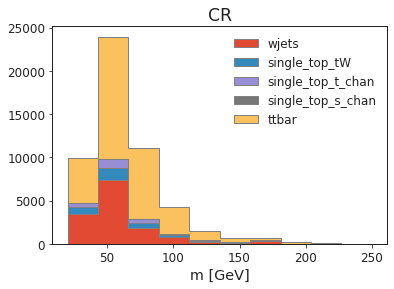

In [9]:
all_histograms[:, "CR", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title("CR");

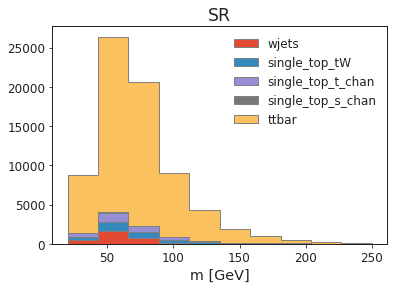

In [10]:
all_histograms[:, "SR", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title("SR");

In [11]:
print("SR", sum(all_histograms[:, "SR", "ttbar", "nominal"].values())) # total before splitting: 101790.4947274355
print("CR", sum(all_histograms[:, "CR", "ttbar", "nominal"].values()))

SR 63619.86764666777
CR 32766.267183085198


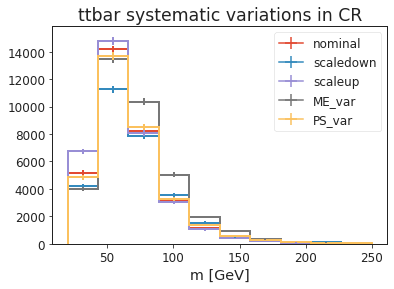

In [12]:
all_histograms[:, "CR", "ttbar", :].stack("variation").plot(linewidth=2)
plt.legend()
plt.title("ttbar systematic variations in CR");

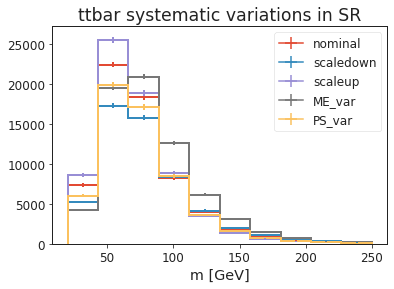

In [13]:
all_histograms[:, "SR", "ttbar", :].stack("variation").plot(linewidth=2)
plt.legend()
plt.title("ttbar systematic variations in SR");

### saving histograms & cabinetry

In [14]:
file_name = "histograms.root"
with uproot.recreate(file_name) as f:
    for region in ["CR", "SR"]:
        f[f"{region}_ttbar"] = all_histograms[:, region, "ttbar", "nominal"]
        f[f"{region}_ttbar_ME_var"] = all_histograms[:, region, "ttbar", "ME_var"]
        f[f"{region}_ttbar_PS_var"] = all_histograms[:, region, "ttbar", "PS_var"]
        f[f"{region}_ttbar_scaledown"] = all_histograms[:, region, "ttbar", "scaledown"]
        f[f"{region}_ttbar_scaleup"] = all_histograms[:, region, "ttbar", "scaleup"]

        f[f"{region}_wjets"] = all_histograms[:, region, "wjets", "nominal"]
        f[f"{region}_single_top_s_chan"] = all_histograms[:, region, "single_top_s_chan", "nominal"]
        f[f"{region}_single_top_t_chan"] = all_histograms[:, region, "single_top_t_chan", "nominal"]
        f[f"{region}_single_top_tW"] = all_histograms[:, region, "single_top_tW", "nominal"]

Control_region_W+jets has empty bins: [7 8 9]
Control_region_single-top,-s-channel has empty bins: [8 9]
Control_region_single-top,-t-channel has empty bins: [8 9]
Signal_region_W+jets has empty bins: [4 5 6 7 8 9]
Control_region_W+jets has empty bins: [7 8 9]
Control_region_single-top,-s-channel has empty bins: [8 9]
Control_region_single-top,-t-channel has empty bins: [8 9]
Signal_region_W+jets has empty bins: [4 5 6 7 8 9]


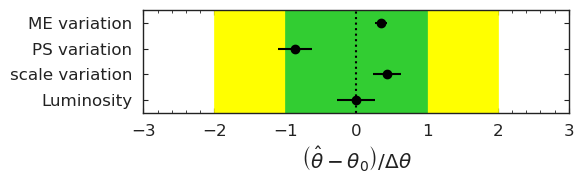

In [15]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)

model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)


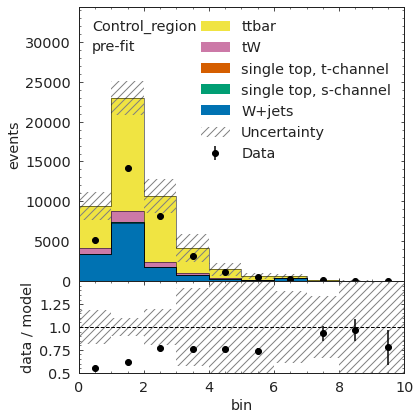

In [16]:
model_prediction = cabinetry.model_utils.prediction(model)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True, log_scale=False)
figs[0]["figure"]

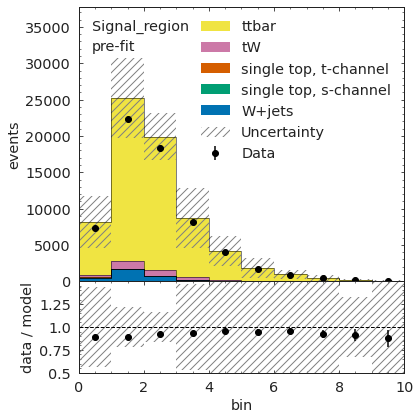

In [17]:
figs[1]["figure"]